In [1]:
from itertools import product

import numpy as np
import pandas as pd
from scipy.stats import gmean
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from doe_modules.preferences import harmonic_mean
from doe_modules.preferences import kwarg_savefig, outputdir, harmonic_mean
from doe_modules.ml import plot_pr, plot_roc
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score
from sklearn.linear_model import LogisticRegression

from doe_modules.simulation.esm9_metrics import *

In [2]:
# top10 = np.array([
#     "positive_pathway_coverage", 
#     "max_positive_edge_density", 
#     "max_positive_cascade_length_ratio", 
#     "edge_effectivity",
#     "mean_factor_density",
#     "max_synergetic_edge_density",
#     "mean_positive_edge_density",
#     "pathway_coverage",
#     "max_cascade_length_ratio",
#     "effective_edge_positivity"
# ])

negs = [
    "max_positive_edge_density", 
    "max_positive_cascade_length_ratio", 
    "max_synergetic_edge_density",
    "mean_positive_edge_density",
    "effective_edge_positivity"
]

key_features = [
    "positive_pathway_coverage", 
    "max_positive_edge_density", 
    "max_synergetic_edge_density",
    "mean_positive_edge_density",
    "pathway_coverage",
    "effective_edge_positivity"
]

In [3]:
from tqdm.notebook import tqdm

edges = np.load(f"{outputdir}/esm_test9_edges.npy")

n = (lambda arr: (-1 + np.sqrt(1 + 8 * arr.size)) / 2)(edges[0])
ppc = np.fromiter(map(positive_pathway_coverage, edges), float).reshape(-1, 1)
maxped = np.fromiter(map(lambda arr: 1 - max_positive_edge_density(arr), edges), float).reshape(-1, 1)
maxsed = np.fromiter(map(lambda arr: 1 - max_synergetic_edge_density(arr), edges), float).reshape(-1, 1)
meanped = np.fromiter(map(lambda arr: 1 - mean_positive_edge_density(arr), edges), float).reshape(-1, 1)
pc = np.fromiter(map(pathway_coverage, edges), float).reshape(-1, 1)
eep = np.fromiter(map(lambda arr: 1 - effective_edge_positivity(arr), edges), float).reshape(-1, 1)

full = np.hstack([ppc, maxped, maxsed, meanped, pc, eep])


df = pd.concat(
    [
        pd.read_feather(f"{outputdir}/esm_test9.feather"),
        pd.DataFrame(
            full,
            columns=key_features
        ),
        pd.DataFrame({
            f"arithmetic{i + 1}": mat.mean(axis=1) for i, mat in tqdm(enumerate(
                [
                    full[:, np.where(arr_bool)[0]] for arr_bool in map(
                        lambda lst_bool: np.array(lst_bool), 
                        product(*[[True, False]] * 6)
                    ) if arr_bool.sum() > 1
                ]
            ))
        })
    ],
    axis=1
)

df = df.assign(
    better_with_pb=df.pb > df.cloo
)

0it [00:00, ?it/s]

In [4]:
df

,cloo,pb,v,,positive_pathway_coverage,max_positive_edge_density,max_synergetic_edge_density,mean_positive_edge_density,pathway_coverage,effective_edge_positivity,...,arithmetic49,arithmetic50,arithmetic51,arithmetic52,arithmetic53,arithmetic54,arithmetic55,arithmetic56,arithmetic57,better_with_pb
0,0.666667,0.526316,1,C+LOO,0.222222,0.583333,0.583333,0.891667,0.666667,0.583333,...,0.686111,0.737500,0.611111,0.625000,0.583333,0.713889,0.779167,0.737500,0.625000,False
1,1.000000,0.181818,1,C+LOO,0.111111,0.705882,0.705882,0.958333,0.555556,0.647059,...,0.770425,0.832108,0.636166,0.630719,0.676471,0.720316,0.756944,0.802696,0.601307,False
2,0.000000,0.526316,0,neither,0.333333,0.761905,0.285714,0.933333,0.666667,0.285714,...,0.501587,0.609524,0.412698,0.476190,0.285714,0.628571,0.800000,0.609524,0.476190,True
3,0.307692,0.674699,2,PB,0.333333,0.800000,0.800000,0.958333,0.777778,0.700000,...,0.819444,0.879167,0.759259,0.788889,0.750000,0.812037,0.868056,0.829167,0.738889,True
4,0.000000,0.457831,0,neither,0.111111,0.875000,0.687500,0.983333,0.555556,0.437500,...,0.702778,0.835417,0.560185,0.621528,0.562500,0.658796,0.769444,0.710417,0.496528,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.240964,0.780488,2,PB,0.222222,0.782609,0.782609,0.925000,0.666667,0.565217,...,0.757609,0.853804,0.671498,0.724638,0.673913,0.718961,0.795833,0.745109,0.615942,True
19996,0.000000,0.000000,0,neither,0.222222,0.956522,0.478261,0.991667,0.777778,0.347826,...,0.605918,0.734964,0.534622,0.628019,0.413043,0.705757,0.884722,0.669746,0.562802,False
19997,0.156250,0.228571,0,neither,0.444444,0.681818,0.500000,0.925000,0.777778,0.454545,...,0.626515,0.712500,0.577441,0.638889,0.477273,0.719108,0.851389,0.689773,0.616162,True
19998,0.357143,0.000000,0,neither,0.444444,0.678571,0.678571,0.841667,0.888889,0.392857,...,0.637698,0.760119,0.653439,0.783730,0.535714,0.707804,0.865278,0.617262,0.640873,False


from sklearn.metrics import confusion_matrix

In [5]:
import seaborn as sns

In [6]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score, recall_score, precision_score

import warnings
warnings.simplefilter('ignore')

fig, ax = plt.subplots(figsize=(3, 3))

metrics = {
    # "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    # "specificity": specificity_score,
    "F$_1$": f1_score,
    # "AUROC": roc_auc_score,
    # "AP": average_precision_score,
}

argmax_recorder = {}

cmap = sns.color_palette("husl", len(metrics))

for  i, (k, metric) in enumerate(metrics.items()):
    x, y = cai_performance_plot(df, metric)
    ax.plot(x, y, color=cmap[i])
    idx = np.argmax(y)
    argmax_max = (x[idx], y[idx])
    ax.scatter(
        *argmax_max, 
        label=f"{k} ({argmax_max[1].round(3)})",
        color=cmap[i]
    )
    ax.vlines(*argmax_max, -0.05, color=cmap[i], linestyle="--", zorder=-100, alpha=.3)
    ax.text(argmax_max[0], .03, "$\leq$" + f"{argmax_max[0].round(2)}", color=cmap[i], ha="left", va="bottom")
    
    argmax_recorder = {**argmax_recorder, k: argmax_max[0]}

ax.set_xlim(-.05, 1.05)
ax.set_ylim(-.05, 1.05)

ax.legend(loc="center left", bbox_to_anchor=(1, .5), fontsize="small")

ax.set_title("Decision thresholds for\nadopting PB designs (ESM9)", size="medium")
ax.set(xlabel="CAI", ylabel="scores")

fig.savefig(f"{outputdir}/decision_thresh_test9", **kwarg_savefig)

In [7]:
def div22():
    weight = np.array([1 / n, 1 - (1 / n)])
    val = np.hstack([
        ppc, 
        maxped
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div3():
    weight = np.array([1, n, (n + 1) * (n - 1), 1])
    val = np.hstack([
        ppc, 
        maxped,
        meanped,
        pc
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div1234():
    weight = np.array([1, n, n ** 2, 1])
    val = np.hstack([
        ppc, 
        maxped,
        meanped,
        pc
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div123():
    weight = np.array([1, n, n ** 2])
    val = np.hstack([
        ppc, 
        maxped,
        meanped,
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div234():
    weight = np.array([n, n ** 2, 1])
    val = np.hstack([
        maxped,
        meanped,
        pc
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div23():
    weight = np.array([n, n ** 2])
    val = np.hstack([
        maxped,
        meanped,
    ])
    return (weight * val).sum(axis=1) / weight.sum()

In [8]:
# df = pd.concat(
#     [
#         df, 
#         pd.DataFrame(dict(
#             div22=div22(),
#             div3=div3(),
#             div1234=div1234(),
#             div123=div123(),
#             div234=div234(),
#             div23=div23()
#         ))
#     ],
#     axis=1
# )

from sklearn.metrics import f1_score

fig, ax = plt.subplots()

thresh = np.linspace(0, 1, 11)
hoge = pd.DataFrame({
    "thresh": thresh,
    # "div22": np.vectorize(lambda t: f1_score(df.better_with_pb, df.div22 > t))(thresh),
    "arithmetric1": np.vectorize(lambda t: f1_score(df.better_with_pb, df.arithmetic1 > t))(thresh),
    "arithmetric2": np.vectorize(lambda t: f1_score(df.better_with_pb, df.arithmetic2 > t))(thresh),
    "ppc": np.vectorize(lambda t: f1_score(df.better_with_pb, df.positive_pathway_coverage > t))(thresh),
    "mped": np.vectorize(lambda t: f1_score(df.better_with_pb, df.max_positive_edge_density > t))(thresh),
})

for key in [
    # "div22", 
    "arithmetric1", "arithmetric2", "ppc", "mped"]:
    sns.lineplot(
        data=hoge, x="thresh", y=key, label=key, marker="o"
    )
    
ax.set(ylabel="f1")

In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score, recall_score, precision_score, precision_recall_curve

In [10]:
feat_names_short = dict(
    pathway_coverage=r"P%",
    pathway_positivity=r"P$_{(+)}$/P",
    pathway_negativity=r"P$_{(-)}$/P",
    positive_pathway_coverage=r"P$_{(+)}$%",
    negative_pathway_coverage=r"P$_{(-)}$%",
    sparse_pathway_coverage=r"P$_{(0)}$%",
    edge_coverage=r"R%",
    edge_positivity=r"R$_{(+)}$/R",
    edge_negativity=r"R$_{(-)}$/R",
    positive_edge_coverage=r"R$_{(+)}$%",
    negative_edge_coverage=r"R$_{(-)}$%",
    sparse_edge_coverage=r"R$_{(0)}$%",
    edge_effectivity=r"R$^*$/R",
    effective_edge_positivity=r"R$^*_{(+)}$/R$^*$",
    effective_edge_negativity=r"R$^*_{(-)}$/R$^*$",
    max_edge_density=r"MaxRW/R$^*$",
    mean_edge_density=r"RW%",
    max_positive_edge_density=r"MaxRW$_{(+)}$/R$^*$",
    mean_positive_edge_density=r"RW$_{(+)}$%",
    max_synergetic_edge_density=r"MaxRW$_&$/R$^*$",
    mean_synergetic_edge_density=r"RW$_&$%",
    max_factor_density=r"MaxFW/n",
    mean_factor_density=r"FW%",
    max_positive_factor_density=r"MaxFW$_{(+)}$/n",
    mean_positive_factor_density=r"FW$_{(+)}$%",
    max_synergetic_factor_density=r"MaxFW$_&$/n",
    mean_synergetic_factor_density=r"FW$_&$%",
    max_cascade_length_ratio=r"MaxCL/n",
    mean_cascade_length_ratio=r"CL%",
    max_positive_cascade_length_ratio=r"MaxCL$_{(+)}$/n",
    mean_positive_cascade_length_ratio=r"CL$_{(+)}$%",
    max_synergetic_cascade_length_ratio=r"MaxCL$_&$/n",
    mean_synergetic_cascade_length_ratio=r"CL$_&$%",
    # cascade_coverage=r"C%",
    # positive_cascade_coverage=r"C$_+$%",
    # synergetic_cascade_coverage=r"C$_&$%",
)

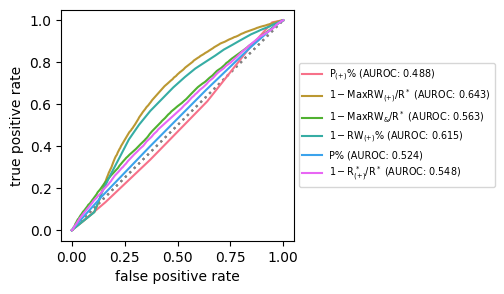

In [11]:
fig, ax = plt.subplots(figsize=(3, 3))

features = [df.loc[:, v] for v in key_features]

names = [
    r"$1-$" + feat_names_short[v] if v in negs else feat_names_short[v] for v in key_features
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    ax.plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1, .5))
ax.set(xlabel="false positive rate", ylabel="true positive rate")

fig.savefig(f"{outputdir}/test9_roc", **kwarg_savefig)

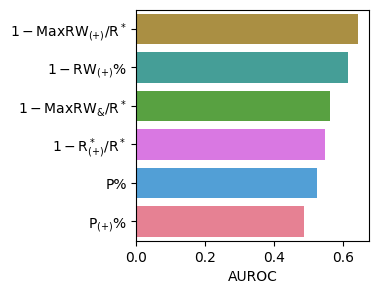

In [12]:
fig, ax = plt.subplots(figsize=(3, 3))

features = [df.loc[:, v] for v in key_features]

names = [
    r"$1-$" + feat_names_short[v] if v in negs else feat_names_short[v] for v in key_features
]

cmap = sns.color_palette("husl", len(features))

df_bar = pd.DataFrame({
    "": names,
    "AUROC": [roc_auc_score(df.better_with_pb, y) for y in features],
    "cmap": cmap
}, index=key_features).sort_values("AUROC", ascending=False)

sns.barplot(
    data=df_bar,
    x="AUROC", y="",
    palette=df_bar.cmap
)

fig.savefig(f"{outputdir}/test9_auc", **kwarg_savefig)

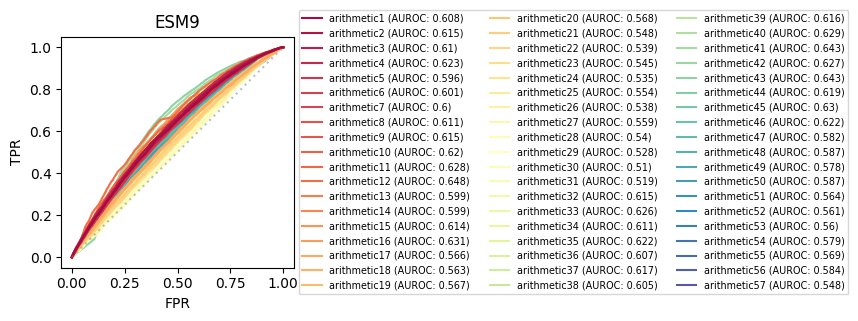

In [110]:
fig, ax = plt.subplots(figsize=(3, 3))

features = [
    eval("df.arithmetic" + f"{i + 1}") for i in range(57)
]

names = [
    f"arithmetic{i + 1}" for i in range(57)
]


cmap = sns.color_palette("Spectral", len(features))

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i],
        zorder=-i
    )

ax.plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1, .5), ncol=3)
ax.set(title="ESM9", xlabel="FPR", ylabel="TPR")

fig.savefig(f"{outputdir}/test9_roc_arithmetic", **kwarg_savefig)

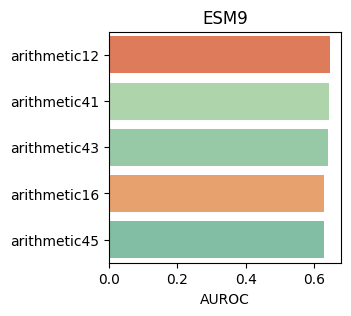

In [14]:
fig, ax = plt.subplots(figsize=(3, 3))

features = [
    eval("df.arithmetic" + f"{i + 1}") for i in range(57)
]

names = [
    f"arithmetic{i + 1}" for i in range(57)
]

df_bar_arith = pd.DataFrame({
    "": names,
    "AUROC": [roc_auc_score(df.better_with_pb, y) for y in features],
    "cmap": sns.color_palette("Spectral", len(features))
}, index=names).sort_values("AUROC", ascending=False).iloc[:5, :]

sns.barplot(
    data=df_bar_arith,
    x="AUROC", y="",
    palette=df_bar_arith.cmap
)

ax.set(title="ESM9")

fig.savefig(f"{outputdir}/test9_auc_arithmetic", **kwarg_savefig)

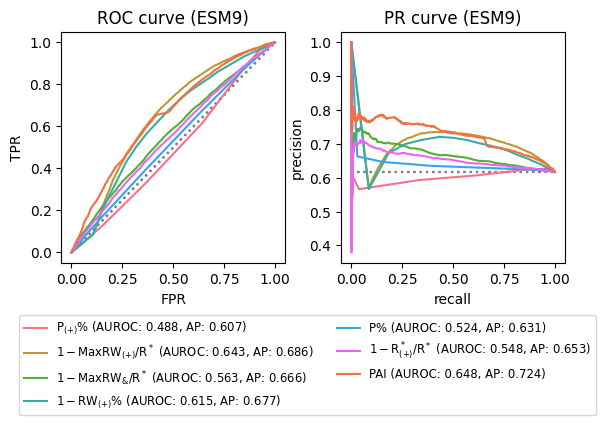

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 3))
plt.subplots_adjust(wspace=.25)

df_concat = pd.concat(
    [
        df_bar.loc[[v for v in df_bar.loc[key_features, :].index if v in key_features], :],
        df_bar_arith.iloc[:1, :]
    ],
    axis=0
)

features = [
    df.loc[:, v] for v in df_concat.index
]

names = [
    r"$1-$" + feat_names_short[v] if v in negs else v for v in df_concat.index
]

names = [
    feat_names_short[v] if v in key_features else v for v in names
]

names = [
    "PAI" if "arithmetic" in v else v for v in names
]


cmap = df_concat.cmap

for i, y in enumerate(features):
    ax[0].plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    ax[0].plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)
    ax[1].plot(
        *precision_recall_curve(df.better_with_pb, y)[:2][::-1], 
        label=names[i] + \
        f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)}, " + \
        f"AP: {average_precision_score(df.better_with_pb, y).round(3)})" , 
        c=cmap[i]
    )
    base = df.better_with_pb.value_counts().cumsum()[0] / df.better_with_pb.value_counts().cumsum()[1]
    ax[1].plot([0, 1], [base, base], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax[1].legend(fontsize="small", loc="upper center", bbox_to_anchor=(-.15, -.2), ncol=2)
ax[0].set(
    title="ROC curve (ESM9)", xlabel="FPR", ylabel="TPR"
)
ax[1].set(title="PR curve (ESM9)", xlabel="recall", ylabel="precision")

fig.savefig(f"{outputdir}/test9_roc_pr_integrated", **kwarg_savefig)

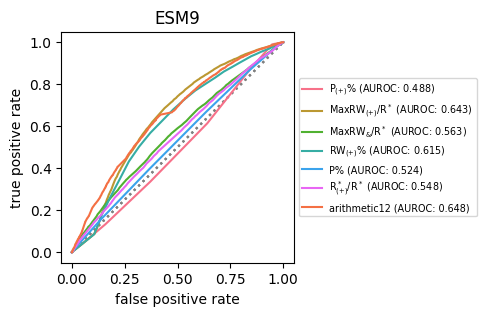

In [97]:
fig, ax = plt.subplots(figsize=(3, 3))

df_concat = pd.concat(
    [
        df_bar.loc[[v for v in df_bar.loc[key_features, :].index if v in key_features], :],
        df_bar_arith.iloc[:1, :]
    ],
    axis=0
)

features = [
    df.loc[:, v] for v in df_concat.index
]

names = [
    feat_names_short[v] if v in key_features else v for v in df_concat.index
]


cmap = df_concat.cmap

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    ax.plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1, .5))
ax.set(title="ESM9", xlabel="false positive rate", ylabel="true positive rate")

fig.savefig(f"{outputdir}/test9_roc_integrated", **kwarg_savefig)

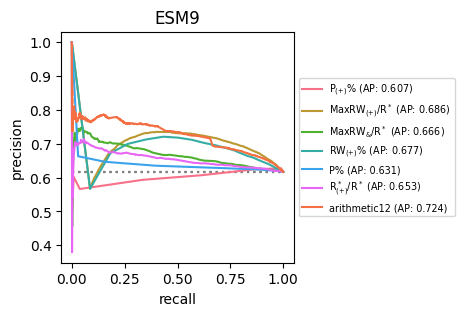

In [98]:
fig, ax = plt.subplots(figsize=(3, 3))

for i, y in enumerate(features):
    ax.plot(
        *precision_recall_curve(df.better_with_pb, y)[:2][::-1], 
        label=names[i] + f" (AP: {average_precision_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    base = df.better_with_pb.value_counts().cumsum()[0] / df.better_with_pb.value_counts().cumsum()[1]
    ax.plot([0, 1], [base, base], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1, .5))
ax.set(title="ESM9", xlabel="recall", ylabel="precision")

fig.savefig(f"{outputdir}/test9_pr", **kwarg_savefig)

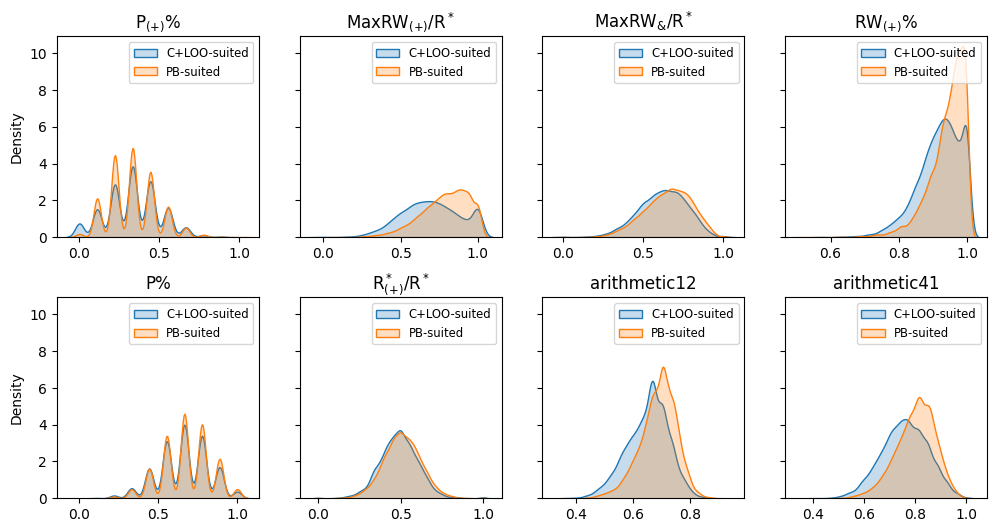

In [18]:
keys = np.array(key_features + ["arithmetic12", "arithmetic41"])

nrow = 2
ncol = np.ceil(keys.size / nrow).astype(int)

fig, ax = plt.subplots(
    nrow, ncol, 
    figsize=(3 * ncol, 3 * nrow), 
    sharey=True
)
plt.subplots_adjust(hspace=0.3, wspace=0.2)

for key, a in zip(keys, ax.ravel()):
    sns.kdeplot(df[key][df.better_with_pb == False], ax=a, label="C+LOO-suited", fill=True)
    sns.kdeplot(df[key][df.better_with_pb == True], ax=a, label="PB-suited", fill=True)
    a.legend(loc="upper right", fontsize="small")
    a.set(
        title=feat_names_short[key] if key in key_features else key, 
        xlabel=""
    )

# if conf.savefig:
#     fig.savefig(f"{conf.out}/top10_kde{conf.suffix}", **kwarg_savefig)

In [19]:
model_phi = np.array([
    1, 1, 0, 0, 0, 1, 1, 0, -1,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 1, 0, 0,
    0, 0, 0, 1, 0, 0,
    -1, 0, 0, 0, 0,
    0, -1, 0, 0,
    -1, 0, 0,
    0, 0,
    1
])

model_psi = np.array([
    1, -1, 0, 0, 0, 0, 1, 1, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    1, -1, 1, -1, 0, 0,
    1, -1, 1, 0, 0,
    1, -1, 0, 0,
    1, 0, 0,
    -1, 0,
    1
])

model_lambda = np.array([
    1, -1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0,
    1, -1, 1, 0, 0,
    0, -1, 0, 0,
    1, 0, 0,
    -1, 1,
    0
])

In [20]:
def pai(arr):
    return np.mean([
        positive_pathway_coverage(arr),
        1 - max_positive_edge_density(arr),
        1 - mean_positive_edge_density(arr)
    ])

In [21]:
df

,cloo,pb,v,,positive_pathway_coverage,max_positive_edge_density,max_synergetic_edge_density,mean_positive_edge_density,pathway_coverage,effective_edge_positivity,...,arithmetic49,arithmetic50,arithmetic51,arithmetic52,arithmetic53,arithmetic54,arithmetic55,arithmetic56,arithmetic57,better_with_pb
0,0.666667,0.526316,1,C+LOO,0.222222,0.583333,0.583333,0.891667,0.666667,0.583333,...,0.686111,0.737500,0.611111,0.625000,0.583333,0.713889,0.779167,0.737500,0.625000,False
1,1.000000,0.181818,1,C+LOO,0.111111,0.705882,0.705882,0.958333,0.555556,0.647059,...,0.770425,0.832108,0.636166,0.630719,0.676471,0.720316,0.756944,0.802696,0.601307,False
2,0.000000,0.526316,0,neither,0.333333,0.761905,0.285714,0.933333,0.666667,0.285714,...,0.501587,0.609524,0.412698,0.476190,0.285714,0.628571,0.800000,0.609524,0.476190,True
3,0.307692,0.674699,2,PB,0.333333,0.800000,0.800000,0.958333,0.777778,0.700000,...,0.819444,0.879167,0.759259,0.788889,0.750000,0.812037,0.868056,0.829167,0.738889,True
4,0.000000,0.457831,0,neither,0.111111,0.875000,0.687500,0.983333,0.555556,0.437500,...,0.702778,0.835417,0.560185,0.621528,0.562500,0.658796,0.769444,0.710417,0.496528,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.240964,0.780488,2,PB,0.222222,0.782609,0.782609,0.925000,0.666667,0.565217,...,0.757609,0.853804,0.671498,0.724638,0.673913,0.718961,0.795833,0.745109,0.615942,True
19996,0.000000,0.000000,0,neither,0.222222,0.956522,0.478261,0.991667,0.777778,0.347826,...,0.605918,0.734964,0.534622,0.628019,0.413043,0.705757,0.884722,0.669746,0.562802,False
19997,0.156250,0.228571,0,neither,0.444444,0.681818,0.500000,0.925000,0.777778,0.454545,...,0.626515,0.712500,0.577441,0.638889,0.477273,0.719108,0.851389,0.689773,0.616162,True
19998,0.357143,0.000000,0,neither,0.444444,0.678571,0.678571,0.841667,0.888889,0.392857,...,0.637698,0.760119,0.653439,0.783730,0.535714,0.707804,0.865278,0.617262,0.640873,False


In [22]:
from sklearn.metrics import r2_score

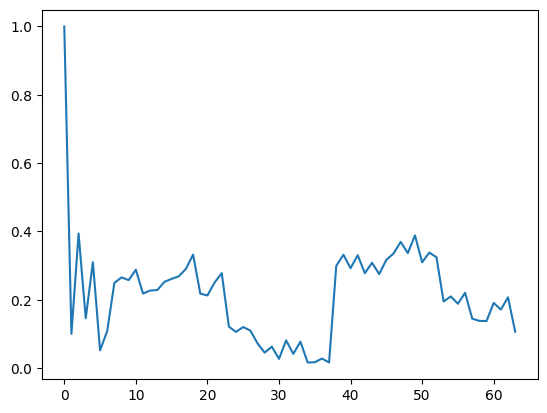

In [23]:
plt.plot(
    pd.concat([df.pb - df.cloo, df.iloc[:, 4:-1]], axis=1).corr().abs().iloc[:, 0].values
)

<Axes: >

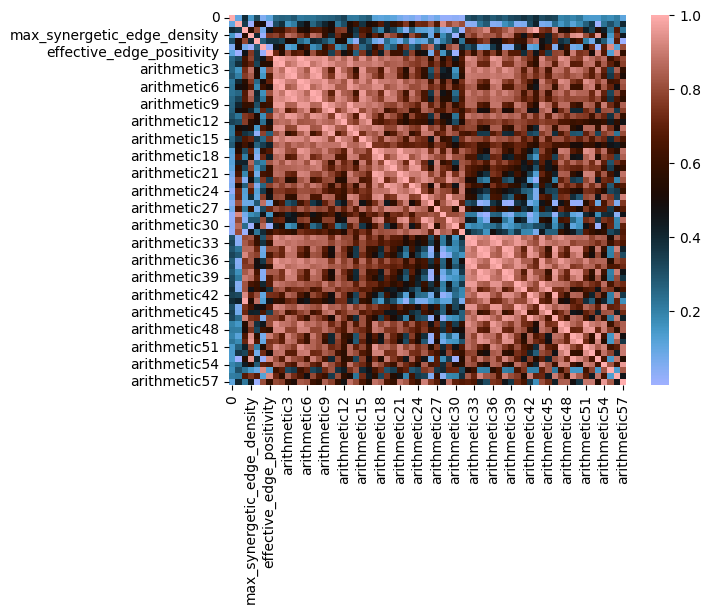

In [28]:
sns.heatmap(
    pd.concat(
        [df.pb - df.cloo, df.iloc[:, 4:-1]], axis=1
    ).corr().abs(),
    cmap="berlin"
)

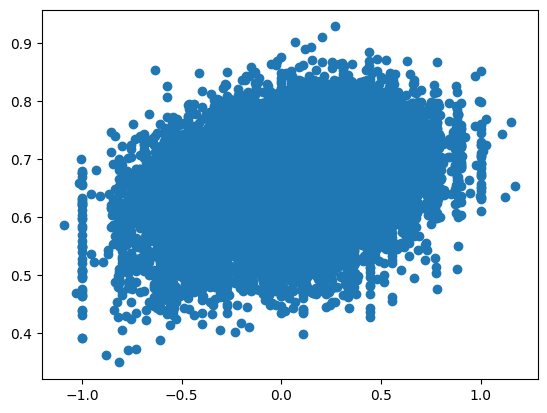

In [29]:
plt.scatter(df.pb - df.cloo, df.arithmetic12)

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
def tp(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    return mat[1, 1] / mat[1].sum()

def fp(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    return mat[0, 1] / mat[0].sum()

In [75]:
vals = np.sort(df.arithmetic12.unique())

fps = np.vectorize(
    lambda t: fp(df.better_with_pb, df.arithmetic12 > t)
)(vals)

tps = np.vectorize(
    lambda t: tp(df.better_with_pb, df.arithmetic12 > t)
)(vals)

acc = np.vectorize(
    lambda t: accuracy_score(df.better_with_pb, df.arithmetic12 > t)
)(vals)

f1 = np.vectorize(
    lambda t: f1_score(df.better_with_pb, df.arithmetic12 > t)
)(vals)

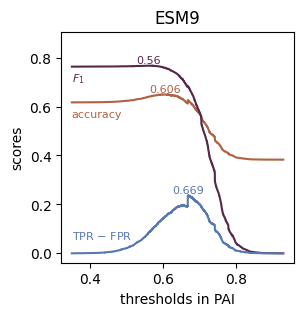

In [99]:
fig, ax = plt.subplots(figsize=(3, 3))

# thresh = np.linspace(0, 1, 21)
df_thresh = pd.DataFrame({
    "thresh": vals,
    "accuracy": acc,
    "$F_1$": f1,
    "TPR $-$ FPR": tps - fps,
})


metrics = np.array(["accuracy", "$F_1$", "TPR $-$ FPR"])
thresh_recorder = {}
cmap = [
    plt.cm.managua(
        (i + 1) / (metrics.size + 1)
    ) for i in range(metrics.size)
]

for i, key in enumerate(metrics):
    v = df_thresh.loc[:, key].values
    argmax = np.argmax(v)

    sns.lineplot(
        data=df_thresh, x="thresh", y=key, 
        label=f"{key} (argmax: {vals[argmax].round(3)})",
        c=cmap[i]
    )
    ax.text(
        vals[argmax], v[argmax], vals[argmax].round(3),
        ha="center", va="bottom", c=cmap[i], size=8
    )
    ax.text(
        vals[0], v[0], 
        key + "\n" if v[0] < .5 else "\n\n" + key, 
        ha="left", 
        va="bottom" if v[0] < .5 else "center", c=cmap[i],
        size=8
    )
    thresh_recorder = {**thresh_recorder, key: vals[argmax]}
    

ax.set(
    title="ESM9",
    xlabel="thresholds in PAI", ylabel="scores",
    ylim = np.array(ax.get_ylim()) + np.array([0, .1])
)
# ax.legend(fontsize="x-small")
ax.legend().remove()


fig.savefig(f"{outputdir}/test9_thresholds", **kwarg_savefig)

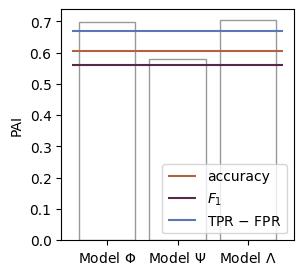

In [100]:
fig, ax= plt.subplots(figsize=(3, 3))

sns.barplot(
    data=pd.DataFrame({
        "": ["Model $\Phi$", "Model $\Psi$", "Model $\Lambda$"],
        "PAI": map(pai, [model_phi, model_psi, model_lambda])
    }),
    x="", y="PAI", ax=ax, color="w", edgecolor=".6"
)

xlim = ax.get_xlim()

for i, (k, v) in enumerate(thresh_recorder.items()):
    c = [
        plt.cm.managua(
            (i + 1) / (metrics.size + 1)
        ) for i in range(metrics.size)
    ]
    ax.hlines(v, *xlim, color=c[i], label=k)
    # ax.text(
    #     2, v, 
    #     "$F_1$" if k == "f1" else k, size=9, 
    #     ha="center", va="top" if i == 1 else "bottom", color=c[i])
    
ax.legend(loc="lower right")

fig.savefig(f"{outputdir}/test9_simulators", **kwarg_savefig)

In [75]:
model_psi2 = np.array([
    -1, -1, 0, 0, 0, 0, 1, -1, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    1, -1, 1, -1, 0, 0,
    1, -1, 1, 0, 0,
    1, 1, 0, 0,
    1, 0, 0,
    -1, 0,
    1
])

In [121]:
model_psi2 = np.array([
    -1, -1, 0, 0, 0, 0, 1, -1, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    1, -1, 1, -1, 0, 0,
    1, -1, 1, 0, 0,
    1, -1, 0, 0,
    1, 0, 0,
    -1, 0,
    1
])

In [122]:
pai(model_psi2)

0.5052188552188552

In [123]:
from doe_modules.simulation import Test9

Text(0.5, 1.0, '$\\Psi 2$')

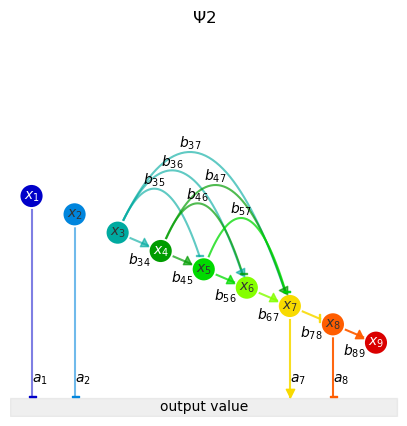

In [124]:
fig, ax = plt.subplots(figsize=(5, 5))

esm9 = Test9(
    edge_assignsment=model_psi2,
)

esm9.plot(ax=ax)

ax.set_title("$\Psi 2$")

In [125]:
from doe_modules.design import CLOO, PlackettBurman
from doe_modules.simulation import MLR, TheoreticalEffects

In [126]:
noise_arr = [.5, 1, 2, 4]

noise_conf = [
    dict(kwarg_err=dict(loc=0, scale=sigma)) for sigma in noise_arr
]

noise_names = [
    "$\sigma=" + f"{sigma}$" for sigma in noise_arr
]

n_arr = np.arange(1, 11)
n_rep=10

np.random.seed(0)
seeds = np.random.randint(0, 2**32, n_rep)

conditions = dict(
    pb=[Test9(edge_assignsment=model_psi2)] * len(noise_conf) * len(n_arr) * seeds.size,
    cloo=[Test9(edge_assignsment=model_psi2)] * len(noise_conf) * len(n_arr) * seeds.size,
)

designs = dict(
    pb=PlackettBurman,
    cloo=CLOO,
)

In [127]:
# period: n_noise >> n_rep >> conf.n_rep

for k, models in conditions.items():
    [
        m.simulate(
            design=designs[k],
            n_rep=n_arr[(i // n_rep) % len(n_arr)],
            random_state=seeds[i % n_rep],
            model_kwargs=noise_conf[i // (n_rep * len(n_arr))],
        ) for i, m in enumerate(models)
    ]
    
theoretical = [
    TheoreticalEffects(
        simulation=Test9(edge_assignsment=model_psi2), random_state=0, model_kwargs=nc
    ) for nc in noise_conf
]

ground_truth = [
    theoretical[i].summary(dtype=int) for i in np.tile(
        np.arange(len(noise_conf)), 
        len(n_arr) * seeds.size
    ).reshape(-1, len(noise_conf)).T.ravel()
]

In [128]:
from doe_modules.preferences import kwarg_err

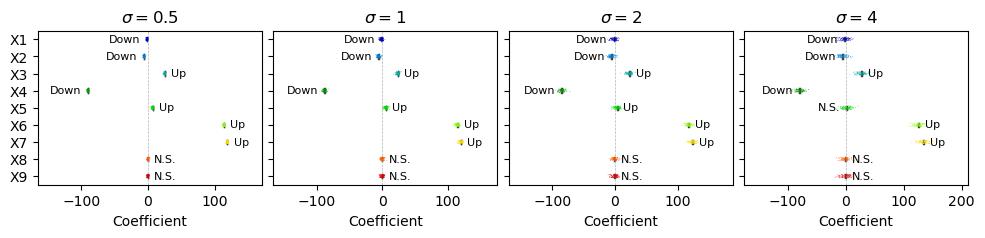

In [129]:
fig, ax = plt.subplots(1, len(noise_arr), figsize=(3 * len(noise_arr), 2), sharey=True)
plt.subplots_adjust(wspace=0.05)

for t, sigma, a in zip(theoretical, noise_conf, ax.ravel()):
    t.plot(ax=a, jitter_ratio=.04, xscales=np.array([1.6, 1.3]), size=.5, **kwarg_err)

    a.set(ylabel="", title="$\sigma=" + f"{sigma['kwarg_err']['scale']}" + "$")

# if conf.savefig:
#     fig.savefig(f"{conf.out}/groundtrue_results{conf.suffix}", **kwarg_savefig)

In [130]:
import warnings
from sklearn.metrics import cohen_kappa_score
from doe_modules.design import d_criterion

import statsmodels.api as sm

In [131]:
warnings.simplefilter('ignore')

pb_metric, cloo_metric = [], []
pb_dd, cloo_dd = [], []
# acc = lambda res, gt: np.nan if res.isna().all() else (1 - (gt - res).abs() / 2).mean()
kappa = lambda res, gt: np.nan if res.isna().all() else cohen_kappa_score(res, gt, weights="linear")

metric = kappa

for pb, cloo, gt in tqdm(
    zip(conditions["pb"], conditions["cloo"], ground_truth), 
    total=len(ground_truth)
):
    pb_res = MLR(pb).summary(anova=True, dtype=int)
    cloo_res = MLR(cloo).summary(anova=True, dtype=int)
    pb_metric += [metric(pb_res, gt)]
    cloo_metric += [metric(cloo_res, gt)]
    pb_dd += [d_criterion(sm.add_constant(pb.exmatrix))]
    cloo_dd += [d_criterion(sm.add_constant(cloo.exmatrix))]

  0%|          | 0/400 [00:00<?, ?it/s]

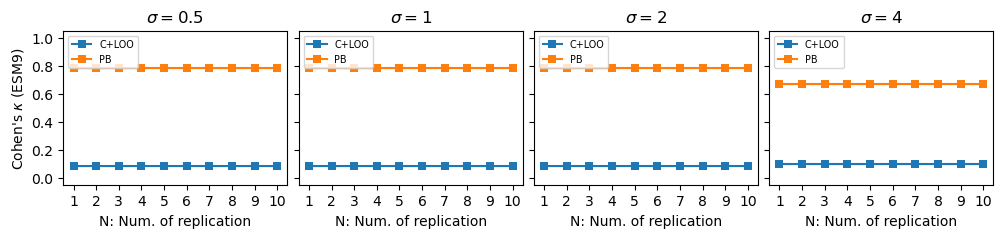

In [132]:
fig, ax = plt.subplots(1, len(noise_arr), figsize=(3 * len(noise_arr), 2), sharey=True)
plt.subplots_adjust(wspace=0.05)

df2 = pd.DataFrame({
    "n": np.tile(
        np.tile(n_arr, seeds.size).reshape(-1, len(n_arr)).T.ravel(), 
        len(noise_conf)
    ),
    "err": np.ravel([[v] * len(n_arr) * seeds.size for v in noise_arr]),
    "pb_metric": pb_metric,
    "cloo_metric": cloo_metric,
    "pb_dd": pb_dd,
    "cloo_dd": cloo_dd,
})

for i, a in enumerate(ax.ravel()):
    e = df2.err.unique()[i]
    sns.lineplot(
        data=df2[df2.err == e], x="n", y="cloo_metric", marker="s", 
        ax=a, label=conditions["cloo"][0].metadata["design"], 
        markeredgewidth=0, errorbar=("ci", 95), n_boot=1000
    )
    sns.lineplot(
        data=df2[df2.err == e], x="n", y="pb_metric", marker="s", 
        ax=a, label=conditions["pb"][0].metadata["design"],
        markeredgewidth=0, errorbar=("ci", 95), n_boot=1000
    )
    a.set_ylim(-0.05, 1.05)
    a.set_xticks(n_arr.tolist())
    a.set_yticks(np.linspace(0, 1, 6).tolist())
    a.set(
        title=noise_names[i], xlabel="N: Num. of replication", 
        ylabel=f"Cohen's $\kappa$ ({model.name})"
    )
    a.legend(loc="upper left", fontsize="x-small")

# fig.suptitle(f"Weighted accuracy score ({conf.simulator().name})", y=1.05)

# if conf.savefig:
#     fig.savefig(f"{conf.out}/benchmarks{conf.suffix}", **kwarg_savefig)